In [1]:
import random, os, tqdm, time, json
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

random.seed(618)
np.random.seed(907)

new_base_path = os.path.join(
    "/Users/minkexiu/Downloads/",
    "/".join(
        os.getcwd().split("/")[-1*(len(sys.path[-1].split("/")) - 1):]
    ),
)
print("storage dir:", new_base_path)
print("code dir:", os.getcwd())

## 创建文件夹。
if not os.path.exists(new_base_path):
    os.makedirs(
        new_base_path
    )
if not os.path.exists(os.path.join(new_base_path, "preprocessedData")):
    os.makedirs(
        os.path.join(new_base_path, "preprocessedData")
    )
if not os.path.exists(os.path.join(new_base_path, "originalData")):
    os.makedirs(
        os.path.join(new_base_path, "originalData")
    )
if not os.path.exists(os.path.join(new_base_path, "trained_models")):
    os.makedirs(
        os.path.join(new_base_path, "trained_models")
    )

def create_originalData_path(filename_or_path):
    return os.path.join(new_base_path, "originalData", filename_or_path)
def create_preprocessedData_path(filename_or_path):
    return os.path.join(new_base_path, "preprocessedData", filename_or_path)
def create_trained_models_path(filename_or_path):
    return os.path.join(new_base_path, "trained_models", filename_or_path)

def millisec2datetime(timestamp):
    time_local = time.localtime(timestamp/1000)
    return time.strftime("%Y-%m-%d %H:%M:%S", time_local)
    
def run_finish():
    # 假设你的字体文件是 'myfont.ttf' 并且位于当前目录下  
    font = FontProperties(fname="/Users/minkexiu/Documents/GitHub/ML_Tryout/SimHei.ttf", size=24)  
    # 创建一个空白的图形  
    fig, ax = plt.subplots()  
    ax.imshow(
        plt.imread("/Users/minkexiu/Downloads/wallhaven-dgxpyg.jpg")
    )
    # 在图形中添加文字  
    ax.text(
        ax.get_xlim()[1] * 0.5, 
        ax.get_ylim()[0] * 0.5, 
        f"程序于这个点跑完：\n{millisec2datetime(time.time()*1000)}", fontproperties=font, ha="center", va="center", color="red"
    )  
    # 设置图形的布局  
    # ax.set_xlim(0, 1)  
    # ax.set_ylim(0, 1)  
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.patch.set_color("blue")
    # 显示图形  
    plt.show()
        
tqdm.tqdm.pandas() ## 引入这个，就可以在apply的时候用progress_apply了。

import IPython
def kill_current_kernel():
    '''杀死当前的kernel释放内存空间。'''
    IPython.Application.instance().kernel.do_shutdown(True) 
    
def simply_show_data(df1):
    print(df1.shape)
    display(df1.head())
    
def wait_flag(saved_flag_path, time_interval_sec=10):
    print("waiting for", saved_flag_path)
    time_count = 0
    while True:
        if os.path.exists(saved_flag_path):
            break
        time.sleep(time_interval_sec)
        time_count+=time_interval_sec
        print(time_count, end=" ")
    print("finish!!")

storage dir: /Users/minkexiu/Downloads/GitHub/ML_runCodeFromBook/大规模语言模型：从理论到实践
code dir: /Users/minkexiu/Documents/GitHub/ML_runCodeFromBook/大规模语言模型：从理论到实践


还可以参考：https://zhuanlan.zhihu.com/p/467103734

In [16]:
import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.distributed.optim import ZeroRedundancyOptimizer
from torch.nn.parallel import DistributedDataParallel as DDP

In [18]:
def print_peak_memory(prefix, device):
    if device == 0:
        print(f"{prefix}: {torch.cuda.max_memory_allocated(device) // 1e6}MB ")

In [20]:
def example(rank, world_size, use_zero):
    '''
    rank实际上是一个device啊，好像不是一个数字。
    '''
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '29500'
    # create default process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)
    # create local model
    model = nn.Sequential(*[nn.Linear(2000, 2000).to(rank) for _ in range(20)])
    print_peak_memory("Max memory allocated after creating local model", rank)
    # construct DDP model
    ddp_model = DDP(model, device_ids=[rank])
    print_peak_memory("Max memory allocated after creating DDP", rank)
    # define loss function and optimizer
    loss_fn = nn.MSELoss()

    if use_zero:
        optimizer = ZeroRedundancyOptimizer( # 这里使用了 ZeroRedundancyOptimizer
            ddp_model.parameters(),
            optimizer_class=torch.optim.Adam, # 包装了 Adam
            lr=0.01
        )
    else:
        optimizer = torch.optim.Adam(ddp_model.parameters(), lr=0.01)


    # forward pass
    outputs = ddp_model(torch.randn(20, 2000).to(rank))
    labels = torch.randn(20, 2000).to(rank)
    # backward pass
    loss_fn(outputs, labels).backward()
    # update parameters
    print_peak_memory("Max memory allocated before optimizer step()", rank)
    optimizer.step()
    print_peak_memory("Max memory allocated after optimizer step()", rank)
    print(f"params sum is: {sum(model.parameters()).sum()}")

In [24]:
## 这个代码在本机跑不了，不知道什么原因。
## 不排除是因为我这个机子没有多显卡？
def main():
    world_size = 2
    print("=== Using ZeroRedundancyOptimizer ===")
    mp.spawn(
        example,
        args=(0, world_size, True), ## 书里给的例子，这里是跑不了的。
        nprocs=world_size,
        join=True
    )
    print("=== Not Using ZeroRedundancyOptimizer ===")
    mp.spawn(
        example,
        args=(1, world_size, False), ## 跑不了是因为这里少了一个参数。。。
        nprocs=world_size,
        join=True
        
    )
if __name__=="__main__":
    main()

=== Using ZeroRedundancyOptimizer ===


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/ml12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'example' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/ml12/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml12/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ProcessExitedException: process 0 terminated with exit code 1

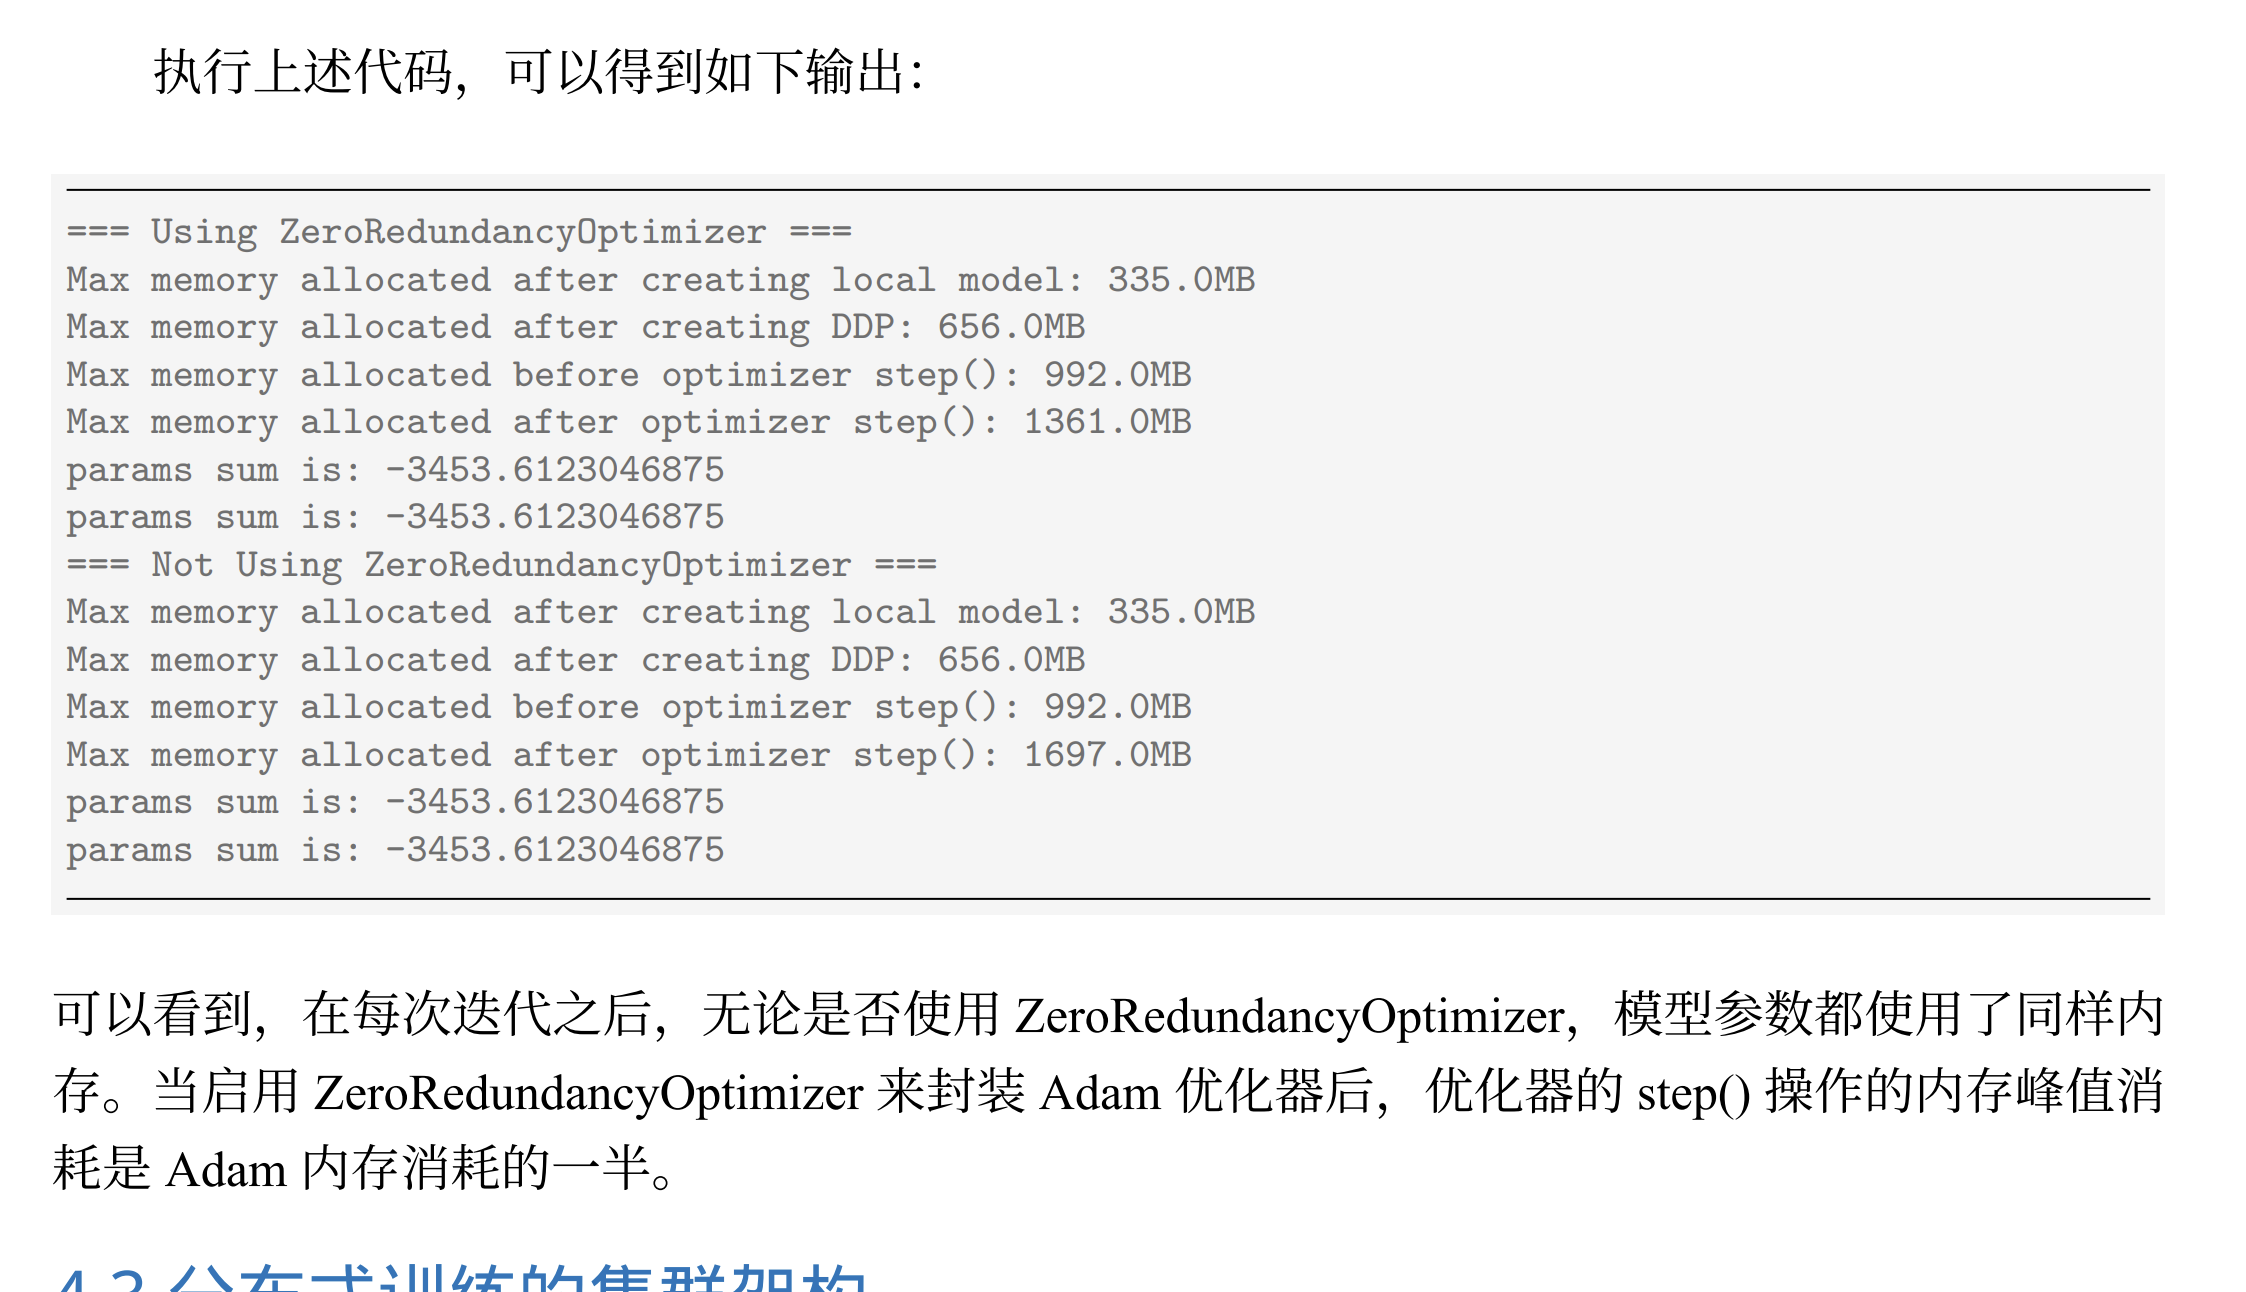

In [17]:
torch.cuda.max_memory_allocated(
    torch.device("mps")
)
## 好像可以看占用显存的量诶。

0

In [15]:
# torch.nn.parallel.DistributedDataParallel?